In [1]:
%matplotlib inline
#from bokeh.io import output_notebook
#rom bokeh.plotting import *
from matmodlab2 import *
from numpy import *
#output_notebook()
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import dill
import sys
from numpy import cos, sin
from sklearn.linear_model import LinearRegression
from wccm_support import plot_Y_components
import matplotlib.tri as tri


run_id = 1

Setting up the Matmodlab notebook environment


In [2]:
def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])
    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())

align_axes_with_pi_plane_rot = align_axes_with_pi_plane_rot()
align_pi_plane_with_axes_rot = align_pi_plane_with_axes_rot()

def run_ST_GPSR_TTM(property_dict, loads='ESS', components=(0.02, 0, 0), frames=50):
    mps1 = MaterialPointSimulator('ST_GPSR_TTM')
    mps1.material = ST_GPSR_TTM(**property_dict)
    mps1.run_step(loads,  components, frames=frames)
    return mps1

def draw_principal_axes(ax, length_of_axes=2.5, scale=100):
    """
    Draws principal axes on graph, change length of axes and scale
    """
    zero_pos = np.zeros(2)
    straight_up_pos = np.array([0, 1]) * length_of_axes
    bottom_right_pos = np.array([np.cos(-np.pi / 6.), np.sin(-np.pi / 6.)]) * length_of_axes
    bottom_left_pos = np.array([np.cos(7 * np.pi / 6.), np.sin(7 * np.pi / 6.)]) * length_of_axes

    ax.quiver(*zero_pos, *straight_up_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_2$", straight_up_pos + np.array([0.25, -0.3]) * scale)

    ax.quiver(*zero_pos, *bottom_right_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_1$", bottom_right_pos + np.array([-0.18, 0.45]) * scale)

    ax.quiver(*zero_pos, *bottom_left_pos, scale_units="xy", scale=1)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.1, -0.45]) * scale)
    ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.28, -0.4]) * scale)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([-0.18, -0.4]) * scale)

In [3]:
#""" Force deviatoric independence on a BINGO solution
def A_mapping(real_eqps  ):
    X_0 = real_eqps
    B_in = ((X_0) * (array([[ 0.4609263 ,  1.10732082, -1.64235896],
       [-5.78728213, -1.14002744, -7.41592524],
       [ 3.98790411,  2.2067136 ,  5.84326082]])) + array([[-0.03862302, -0.03187797,  0.20941924],
       [ 0.88568078,  0.49687034,  1.68504125],
       [-0.27601273, -0.15597089, -0.63898822]])) @ ((((X_0) * (array([[ 0.4609263 ,  1.10732082, -1.64235896],
       [-5.78728213, -1.14002744, -7.41592524],
       [ 3.98790411,  2.2067136 ,  5.84326082]])) + array([[-0.03862302, -0.03187797,  0.20941924],
       [ 0.88568078,  0.49687034,  1.68504125],
       [-0.27601273, -0.15597089, -0.63898822]])) @ (array([[ 0.70828347, -0.98725251,  0.28020231],
       [-1.25898614,  1.05867731,  0.20430282],
       [ 0.23715242,  0.0628872 , -0.30324894]]))) @ (((X_0) * (array([[ 0.4609263 ,  1.10732082, -1.64235896],
       [-5.78728213, -1.14002744, -7.41592524],
       [ 3.98790411,  2.2067136 ,  5.84326082]])) + array([[-0.03862302, -0.03187797,  0.20941924],
       [ 0.88568078,  0.49687034,  1.68504125],
       [-0.27601273, -0.15597089, -0.63898822]])) @ (array([[ 0.70828347, -0.98725251,  0.28020231],
       [-1.25898614,  1.05867731,  0.20430282],
       [ 0.23715242,  0.0628872 , -0.30324894]]))))
    #B_in *= (ISO_Y_0 + ISO_H*fict_eqps)
    B_in = align_axes_with_pi_plane_rot.T @ B_in @ align_axes_with_pi_plane_rot
    B_in[:, 2] = 0
    B_in[2, :] = 0
    B_in[2, 2] = 1
    B_in = align_axes_with_pi_plane_rot @ B_in @ align_axes_with_pi_plane_rot.T
    new_B = np.zeros((6,6))
    new_B[0:3, 0:3] = B_in
    new_B[3:, 3:] = np.eye(3) # Like the stuffness matrix, the shear comps are multiplied by ROOT2
    return new_B
#"""

# Shared params
E = 50e3
nu = .333

# Build the loading paths
rotation_angles = np.linspace(0,2*np.pi, 91)
axial_E = 0.1

pairs_master = [( 0, 1, 2 ), ( 1, 2, 0 ), ( 0, 2, 1 )]
pairs = [ pairs_master[ run_id ] ]
load_string_master = [ 'EES', 'SEE', 'ESE' ]
load_string = [ load_string_master[run_id] ]
pair_comps = [] 

load_comps = []
for i, pair in enumerate(pairs):
    local_comps = []
    local_load_comps = []
    a1 = pair[0]
    a2 = pair[1]
    s_index = pair[2]

    for ang in rotation_angles:
        local_load_comps.append(load_string[i])
        load_reference = [ 0, 0, 0 ]
        load_reference[a1] = axial_E * np.cos(ang)
        load_reference[a2] = axial_E * np.sin(ang)
        load_reference[s_index] = 0
        #print(F_reference)
        #rotation = rotations[rot](ang)
        # F_reference = F_reference.reshape(3,3)
        # F = np.dot(rotation, F_reference)
        # F = tuple(F.flatten())
        local_comps.append(load_reference)
    pair_comps.append(local_comps)
    load_comps.append(local_load_comps)

all_frames = 50

In [4]:
run = True
if run:
    results = []
    for comps_summary, load_summary in zip(pair_comps, load_comps):
        comp_results = []
        for comps, load in zip(comps_summary, load_summary):
            print(comps, load)
            # Run ST_GPSR_TTM model
            pGPSR = {'E': E, 'Nu': nu,  "A_mapping": A_mapping}
            #print(comps, all_loads)
            try:
                mpsGPSR = run_ST_GPSR_TTM(pGPSR, frames=all_frames, components=comps, loads=load)
            except Exception as e:
                print(f'Failed on {comps_summary} and {load_summary}')
                print(e)
                continue
            comp_results.append(mpsGPSR)
        results.append(comp_results)


    with open("vpsc_results_12.pkl", "wb") as dill_file:
        dill.dump(results, dill_file)
else:
    with open("vpsc_results_12.pkl", "rb") as dill_file:
        results = dill.load(dill_file)

    # for mps in r:
    #     print(mps.df[['E.XX', 'E.YY', 'E.ZZ']].to_numpy()[-1,:])
    #     ax = mps.plot('E.XX', 'S.XX')
    #     mps.plot('E.XX', 'S.YY', ax=ax)
    #     mps.plot('E.XX', 'S.ZZ', ax=ax)
        


[0, 0.1, 0.0] SEE
[0, 0.09975640502598243, 0.00697564737441253] SEE
[0, 0.09902680687415705, 0.013917310096006545] SEE
[0, 0.09781476007338058, 0.020791169081775935] SEE
[0, 0.0961261695938319, 0.027563735581699916] SEE
[0, 0.09396926207859085, 0.03420201433256687] SEE
[0, 0.0913545457642601, 0.04067366430758002] SEE
[0, 0.0882947592858927, 0.046947156278589086] SEE
[0, 0.0848048096156426, 0.05299192642332049] SEE
[0, 0.08090169943749476, 0.058778525229247314] SEE
[0, 0.0766044443118978, 0.06427876096865393] SEE
[0, 0.07193398003386513, 0.06946583704589973] SEE
[0, 0.06691306063588583, 0.07431448254773942] SEE
[0, 0.06156614753256583, 0.07880107536067221] SEE
[0, 0.055919290347074685, 0.08290375725550418] SEE
[0, 0.05000000000000002, 0.08660254037844387] SEE
[0, 0.043837114678907746, 0.08987940462991671] SEE
[0, 0.0374606593415912, 0.09271838545667875] SEE
[0, 0.030901699437494747, 0.09510565162951536] SEE
[0, 0.02419218955996677, 0.09702957262759965] SEE
[0, 0.017364817766693044, 0.09

[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1       ] [ 7.77329590e-15 -3.22107630e-11 -1.90315637e-14  4.08536086e-11
  6.69032381e-11 -2.68179409e-14  1.10767448e-10 -9.25387765e-11
  5.38640956e-14 -1.98449445e-10] [185.78467017 245.79926075 304.94871468 344.31851263 368.1984636
 387.34169156 405.69303792 421.33585448 432.53823592 442.61573196] [ 64.18629649 101.47511867 130.97916312 147.53754064 154.77125177
 158.64704618 161.46922744 162.46668244 160.90511533 158.38762541]
[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1       ] [ 1.84217693e-11  4.01592419e-11  1.50639771e-10  4.00551701e-11
  1.50795122e-10 -1.78662838e-10  1.92512982e-10 -2.67353731e-10
  2.01434838e-10  3.05839208e-11] [186.95715358 246.02297907 304.55774439 343.33073279 366.82087844
 385.77957277 403.98056939 419.44798307 430.51562267 440.56561593] [ 77.44479896 128.20878413 166.8332492  189.2642

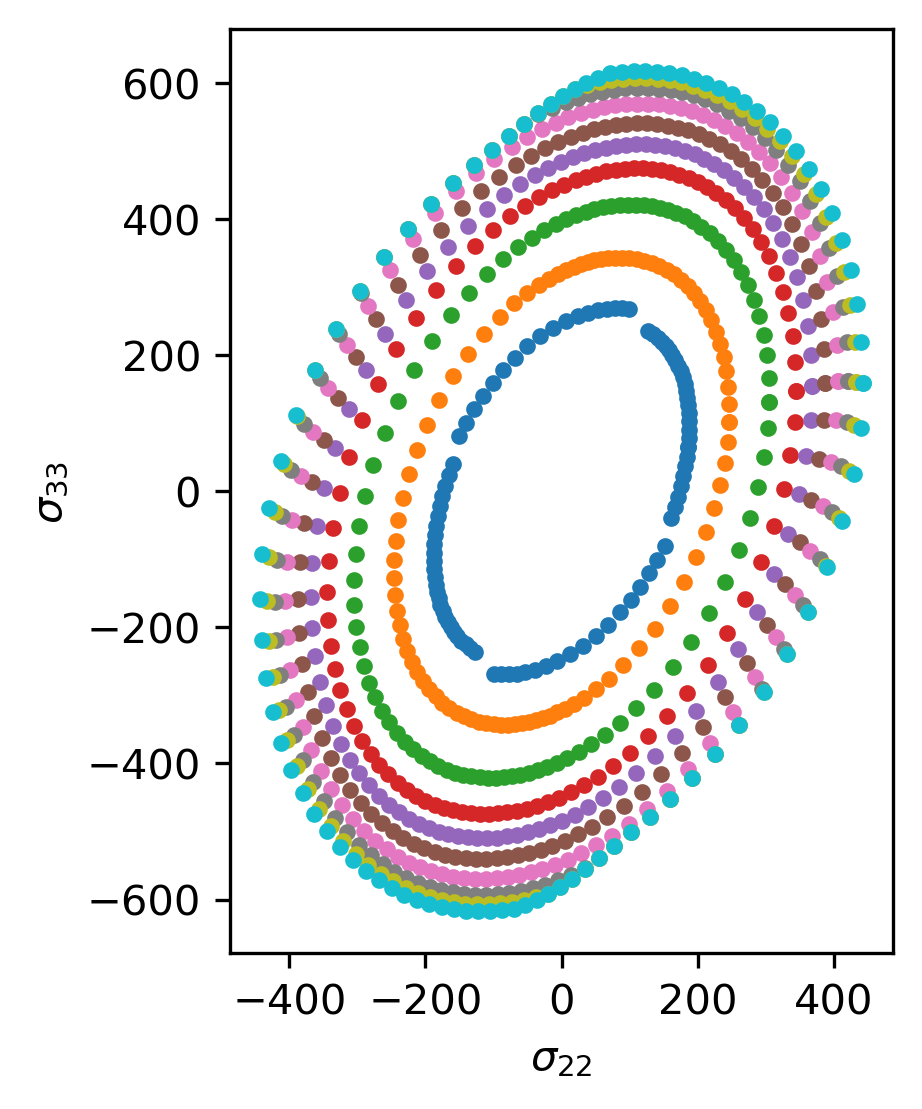

In [6]:
eqps_vals = np.linspace(0, 0.1, 10)#np.array([0.000625*i for i in range(8) ])
if run_id == 0:
    plot_Y_components(results[0], pairs[0], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{22}$'])
elif run_id == 1:
    plot_Y_components(results[0], pairs[0], eqps_vals, ['$\\sigma_{22}$', '$\\sigma_{33}$'])
elif run_id == 2:
    plot_Y_components(results[0], pairs[0], eqps_vals, ['$\\sigma_{11}$', '$\\sigma_{33}$'])

In [7]:
with open("vpsc_results_23.pkl", "wb") as dill_file:
    dill.dump(results, dill_file)
    